In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re
import warnings

## Data Understanding

In [2]:
# Memuat data artikel edukasi kehamilan
file_path = 'edukasi_artikel.csv'
df_articles = pd.read_csv(file_path)

# Menampilkan beberapa data teratas
print(f"Jumlah artikel: {len(df_articles)}")
df_articles.head()

Jumlah artikel: 17


,Kategori,Kondisi,Judul Artikel,Isi Artikel
0,Usia Ibu Hamil,Kurang dari 18 Tahun,Kehamilan di Usia Remaja: Panduan Nutrisi dan ...,Kehamilan di usia remaja (<18 tahun) membawa t...
1,Usia Ibu Hamil,Lebih dari 35 Tahun,Hamil di Atas 35 Tahun: Peluang dan Persiapan ...,Hamil di usia 35 tahun ke atas (sering disebut...
2,Gula Darah Ibu Hamil (BS),Tinggi (Contoh >126 mg/dL puasa atau >140 mg/d...,"Diabetes Gestasional: Kenali Gejala, Penyebab,...",Kadar gula darah tinggi selama kehamilan bisa ...
3,Gula Darah Ibu Hamil (BS),Normal (Contoh puasa 70-100 mg/dL),Menjaga Gula Darah Stabil Selama Kehamilan: Ti...,Mempertahankan kadar gula darah normal selama ...
4,Gula Darah Ibu Hamil (BS),Rendah (Contoh <70 mg/dL),"Hipoglikemia Saat Hamil: Penyebab, Gejala yang...",Meskipun kurang umum dibandingkan gula darah t...


In [3]:
# Mengeksplorasi kolom dan tipe data
df_articles.info()

# Memeriksa distribusi kategori artikel
df_articles['Kategori'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Kategori       17 non-null     object
 1   Kondisi        17 non-null     object
 2   Judul Artikel  17 non-null     object
 3   Isi Artikel    17 non-null     object
dtypes: object(4)
memory usage: 672.0+ bytes


Kategori
Gula Darah Ibu Hamil (BS)            3
Tekanan Darah Sistolik Ibu Hamil     3
Tekanan Darah Diastolik Ibu Hamil    3
Suhu Tubuh Ibu Hamil                 3
Denyut Jantung Ibu Hamil             3
Usia Ibu Hamil                       2
Name: count, dtype: int64

In [4]:
# 📖 Menyiapkan kolom gabungan teks untuk analisis
df_articles['content'] = df_articles['Kategori'] + " " + df_articles['Kondisi'] + " " + df_articles['Judul Artikel'] + " " + df_articles['Isi Artikel']
df_articles[['Judul Artikel', 'content']].head()

,Judul Artikel,content
0,Kehamilan di Usia Remaja: Panduan Nutrisi dan ...,Usia Ibu Hamil Kurang dari 18 Tahun Kehamilan ...
1,Hamil di Atas 35 Tahun: Peluang dan Persiapan ...,Usia Ibu Hamil Lebih dari 35 Tahun Hamil di At...
2,"Diabetes Gestasional: Kenali Gejala, Penyebab,...",Gula Darah Ibu Hamil (BS) Tinggi (Contoh >126 ...
3,Menjaga Gula Darah Stabil Selama Kehamilan: Ti...,Gula Darah Ibu Hamil (BS) Normal (Contoh puasa...
4,"Hipoglikemia Saat Hamil: Penyebab, Gejala yang...",Gula Darah Ibu Hamil (BS) Rendah (Contoh <70 m...


## Data Preparation

In [8]:
df_articles['content'] = (
    df_articles['Kategori'].fillna('') + ' ' +
    df_articles['Kondisi'].fillna('') + ' ' +
    df_articles['Judul Artikel'].fillna('') + ' ' +
    df_articles['Isi Artikel'].fillna('')
)


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_articles['clean_content'] = df_articles['content'].apply(clean_text)

print(df_articles[['content', 'clean_content']].head())


                                             content  \
0  Usia Ibu Hamil Kurang dari 18 Tahun Kehamilan ...   
1  Usia Ibu Hamil Lebih dari 35 Tahun Hamil di At...   
2  Gula Darah Ibu Hamil (BS) Tinggi (Contoh >126 ...   
3  Gula Darah Ibu Hamil (BS) Normal (Contoh puasa...   
4  Gula Darah Ibu Hamil (BS) Rendah (Contoh <70 m...   

                                       clean_content  
0  usia ibu hamil kurang dari tahun kehamilan di ...  
1  usia ibu hamil lebih dari tahun hamil di atas ...  
2  gula darah ibu hamil bs tinggi contoh mgdl pua...  
3  gula darah ibu hamil bs normal contoh puasa mg...  
4  gula darah ibu hamil bs rendah contoh mgdl hip...  


In [13]:
texts = df_articles['clean_content'].tolist()

# Atur tokenizer, misal vocab_size 5000
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

max_len = max(len(seq) for seq in sequences)
print(f"Max sequence length: {max_len}")

Max sequence length: 110


In [ ]:
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

print(padded_sequences.shape) # (jumlah artikel, max_len)

(17, 110)


## Modelling

In [15]:
embedding_dim = 50  # Dimensi embedding yang relatif kecil karena data terbatas

# Model embedding + autoencoder sederhana (mencoba reconstruct teks)
input_seq = Input(shape=(max_len,), name='input_seq')
x = Embedding(vocab_size, embedding_dim, input_length=max_len, name='embedding')(input_seq)
x = GlobalAveragePooling1D()(x)
encoded = Dense(embedding_dim, activation='relu', name='encoded')(x)

In [16]:
# Decoder di-skip, output encoded jadi embedding representasi artikel
model = Model(inputs=input_seq, outputs=encoded)
model.compile(optimizer='adam', loss='mse')

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 110)]             0         
                                                                 
 embedding (Embedding)       (None, 110, 50)           250000    
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 encoded (Dense)             (None, 50)                2550      
                                                                 
Total params: 252,550
Trainable params: 252,550
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
dummy_targets = np.random.rand(len(padded_sequences), embedding_dim)
history = model.fit(
    padded_sequences,
    dummy_targets,
    epochs=10,
    batch_size=8,
    verbose=1
)

Epoch 1/10
3/3 [==============================] - 3s 7ms/step - loss: 0.3254
Epoch 2/10
3/3 [==============================] - 0s 11ms/step - loss: 0.3219
Epoch 3/10
3/3 [==============================] - 0s 8ms/step - loss: 0.3180
Epoch 4/10
3/3 [==============================] - 0s 8ms/step - loss: 0.3137
Epoch 5/10
3/3 [==============================] - 0s 8ms/step - loss: 0.3091
Epoch 6/10
3/3 [==============================] - 0s 7ms/step - loss: 0.3040
Epoch 7/10
3/3 [==============================] - 0s 5ms/step - loss: 0.2986
Epoch 8/10
3/3 [==============================] - 0s 7ms/step - loss: 0.2930
Epoch 9/10
3/3 [==============================] - 0s 7ms/step - loss: 0.2867
Epoch 10/10
3/3 [==============================] - 0s 6ms/step - loss: 0.2801


## Evaluation

In [18]:
article_embeddings = model.predict(padded_sequences)

print("Embedding shape:", article_embeddings.shape)

1/1 [==============================] - 0s 111ms/step
Embedding shape: (17, 50)


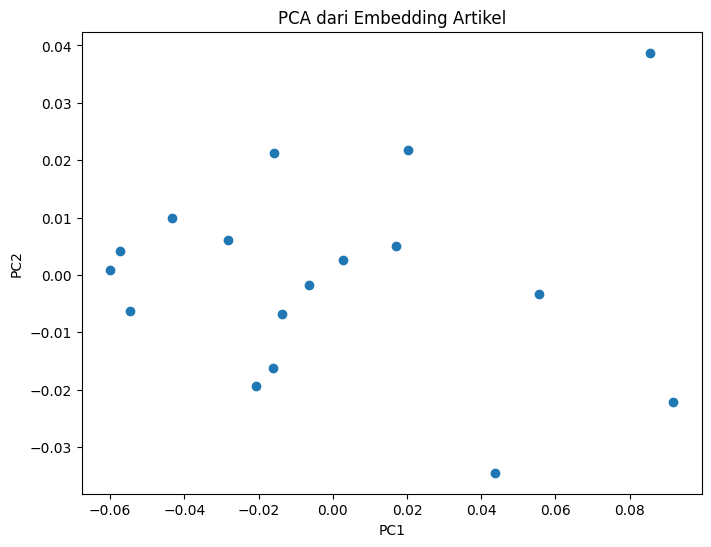

In [21]:
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(article_embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_pca[:,0], emb_pca[:,1])
plt.title('PCA dari Embedding Artikel')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Inference

In [22]:
def map_user_input_to_conditions(age, systolicBP, diastolicBP, bloodsugar, heartrate):
    conditions = []
    if age < 18:
        conditions.append("usia ibu hamil kurang dari 18 tahun")
    elif age > 35:
        conditions.append("usia ibu hamil lebih dari 35 tahun")

    if bloodsugar < 70:
        conditions.append("gula darah ibu hamil rendah")
    elif 70 <= bloodsugar <= 100:
        conditions.append("gula darah ibu hamil normal")
    else:
        conditions.append("gula darah ibu hamil tinggi")

    if systolicBP < 90 or diastolicBP < 60:
        conditions.append("tekanan darah ibu hamil rendah")
    elif (90 <= systolicBP <= 120) and (60 <= diastolicBP <= 80):
        conditions.append("tekanan darah ibu hamil normal")
    else:
        conditions.append("tekanan darah ibu hamil tinggi")

    if heartrate < 60:
        conditions.append("detak jantung ibu hamil rendah")
    elif 60 <= heartrate <= 100:
        conditions.append("detak jantung ibu hamil normal")
    else:
        conditions.append("detak jantung ibu hamil tinggi")

    return " ".join(conditions)

In [28]:
def recommend_articles(user_input, tokenizer, model, max_len, df_articles, article_embeddings, top_n=3):
    user_profile_text = map_user_input_to_conditions(
        user_input['age'],
        user_input['systolicBP'],
        user_input['diastolicBP'],
        user_input['bloodsugar'],
        user_input['heartrate']
    )
    if not user_profile_text:
        print("Tidak ada kondisi relevan dari input pengguna.")
        return pd.DataFrame()
    
    # Preprocessing user profile sama seperti artikel
    user_text_clean = clean_text(user_profile_text)
    seq = tokenizer.texts_to_sequences([user_text_clean])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')

    # Prediksi embedding user
    user_emb = model.predict(padded_seq)

    # Hitung similarity
    sims = cosine_similarity(user_emb, article_embeddings).flatten()

    # Ambil indeks top N artikel
    top_indices = sims.argsort()[::-1][:top_n]

    recommended = df_articles.iloc[top_indices].copy()
    recommended['Similarity'] = sims[top_indices]

    return recommended[['Judul Artikel', 'Kategori', 'Kondisi', 'Similarity', 'Isi Artikel']]


In [29]:
user_input_example = {
    'age': 17,
    'systolicBP': 115,
    'diastolicBP': 75,
    'bloodsugar': 150,
    'heartrate': 90
}

recommended_df = recommend_articles(user_input_example, tokenizer, model, max_len, df_articles, article_embeddings)

print("\nArtikel Rekomendasi untuk input pengguna:")
for idx, row in recommended_df.iterrows():
    print(f"- {row['Judul Artikel']} (Kategori: {row['Kategori']}, Kondisi: {row['Kondisi']})")
    print(f"  Similarity: {row['Similarity']:.3f}")
    print(f"  Ringkasan: {row['Isi Artikel'][:150]}...\n")

1/1 [==============================] - 0s 21ms/step

Artikel Rekomendasi untuk input pengguna:
- Suhu Tubuh Normal: Indikator Kesehatan Ibu Hamil yang Baik (Kategori: Suhu Tubuh Ibu Hamil, Kondisi: Normal (Contoh 36.5 - 37.2°C))
  Similarity: 0.997
  Ringkasan: Suhu tubuh yang stabil dalam rentang normal (36.5 - 37.2°C) adalah salah satu tanda bahwa tubuh Anda berfungsi dengan baik dan bebas dari infeksi akut...

- Memahami Tekanan Darah Diastolik Rendah Selama Masa Kehamilan (Kategori: Tekanan Darah Diastolik Ibu Hamil, Kondisi: Rendah (Contoh <60 mmHg))
  Similarity: 0.996
  Ringkasan: Tekanan darah diastolik di bawah 60 mmHg bisa menjadi bagian dari perubahan fisiologis selama kehamilan, namun jika disertai keluhan signifikan sepert...

- Diastolik Normal, Jantung Sehat: Jaga Tekanan Darah Optimal Selama Kehamilan (Kategori: Tekanan Darah Diastolik Ibu Hamil, Kondisi: Normal (Contoh 60-80 mmHg))
  Similarity: 0.996
  Ringkasan: Tekanan darah diastolik yang berada dalam rentang norma